In [1]:
import numpy as np
import pandas as pd

# Cleaning business Datasets

In [2]:
business = pd.read_csv('business.csv')

In [3]:
business.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [4]:
business.shape

(93487, 11)

In [5]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        93487 non-null  object
 1   airline     93487 non-null  object
 2   ch_code     93487 non-null  object
 3   num_code    93487 non-null  int64 
 4   dep_time    93487 non-null  object
 5   from        93487 non-null  object
 6   time_taken  93487 non-null  object
 7   stop        93487 non-null  object
 8   arr_time    93487 non-null  object
 9   to          93487 non-null  object
 10  price       93487 non-null  object
dtypes: int64(1), object(10)
memory usage: 7.8+ MB


## Clean and process 'stop' column

In [6]:
business['stop'].value_counts()

stop
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t                   81489
non-stop                                                                      8102
2+-stop                                                                       1083
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR\n\t\t\t\t\t\t\t\t\t\t\t\t              810
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t              776
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PAT\n\t\t\t\t\t\t\t\t\t\t\t\t              257
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Patna\n\t\t\t\t\t\t\t\t\t\t\t\t            242
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia BBI\n\t\t\t\t\t\t\t\t\t\t\t\t              152
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia STV\n\t\t\t\t\t\t\t\t\t\t\t\t               93
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXE\n\t\t\t\t\t\t\t\t\t\t\t\t               86
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Bhubaneswar\n\t\t\t\t\t\t\t\t\t\t\t\t       75
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Hyderabad\n\t\t\t\t\t\t\t\t\t\t\t\t         71

In [7]:
business['stop_type'] = business['stop'].str[:8]
business['stop_type'].value_counts()

stop_type
1-stop\n\t    84302
non-stop       8102
2+-stop        1083
Name: count, dtype: int64

In [8]:
business['stop_type'] = business['stop_type'].map({
    '1-stop\n\t': 'one',
    'non-stop': 'zero',
    '2+-stop': 'two+'
})
business.drop('stop', axis=1, inplace=True)

In [9]:
business['stop_type'].value_counts()

stop_type
one     84302
zero     8102
two+     1083
Name: count, dtype: int64

## Process flight codes and airline

In [10]:
business['airline'].value_counts()

airline
Vistara      60589
Air India    32898
Name: count, dtype: int64

In [11]:
business['ch_code'].value_counts()

ch_code
UK    60589
AI    32898
Name: count, dtype: int64

In [12]:
business['flight'] = business['ch_code'] + '-' + business['num_code'].astype('str')
business.drop(['ch_code', 'num_code'], axis=1, inplace=True)

## Convert 'time_taken' to 'duration' (hh:mm into hours)

In [13]:
def convert_to_minutes(time_str):
    try:
        hours, minutes = time_str.split('h ')
        hours = float(hours)
        minutes = float(minutes.replace('m', ''))
        total_minutes = hours * 60 + minutes
        return round(total_minutes / 60, 2)
    except ValueError:
        print(f"Skipping invalid format: {time_str}")
        return np.nan

business['duration'] = business['time_taken'].apply(convert_to_minutes)
business.drop(['time_taken'], axis=1, inplace=True)

## Rename columns

In [14]:
business.rename(columns={
    'dep_time': 'departure_time',
    'arr_time': 'arrival_time',
    'to': 'destination_city',
    'from': 'source_city'
}, inplace=True)

## Categorize 'arrival_time' and 'departure_time'

In [15]:
def categorize_time(time_str):
    hour = int(time_str.split(':')[0])
    if 4 <= hour < 8:
        return 'Early Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 19:
        return 'Early Evening'
    elif 19 <= hour < 22:
        return 'Evening'
    elif 22 <= hour < 24 or 0 <= hour < 4:
        return 'Night'
    else:
        return 'Unknown'

business['arrival_time'] = business['arrival_time'].apply(categorize_time)
business['departure_time'] = business['departure_time'].apply(categorize_time)

## Process 'date' to 'days_left'

In [16]:
dd = pd.DataFrame(business["date"].str.split("-", expand=True).to_numpy().astype(int), columns=["day", "month", "year"])
dd1 = np.where(dd["month"] > 2, dd["day"] + 18, np.where(dd["month"] == 2, dd["day"] - 10, dd["day"]))
business["days_left"] = dd1
business.drop('date', axis=1, inplace=True)

## Process price into integer

In [17]:
business['price'] = business['price'].str.replace(',', '').astype('int')

# **Final Business DataFrame**

In [18]:
business.head()

,airline,departure_time,source_city,arrival_time,destination_city,price,stop_type,flight,duration,days_left
0,Air India,Early Evening,Delhi,Evening,Mumbai,25612,zero,AI-868,2.00,1
1,Air India,Evening,Delhi,Evening,Mumbai,25612,zero,AI-624,2.25,1
2,Air India,Evening,Delhi,Evening,Mumbai,42220,one,AI-531,24.75,1
3,Air India,Evening,Delhi,Night,Mumbai,44450,one,AI-839,26.50,1
4,Air India,Early Evening,Delhi,Night,Mumbai,46690,one,AI-544,6.67,1


# Cleaning Economy datasets

In [19]:
economy = pd.read_csv('economy.csv')

In [20]:
economy.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


In [21]:
economy.shape

(206774, 11)

In [22]:
economy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        206774 non-null  object
 1   airline     206774 non-null  object
 2   ch_code     206774 non-null  object
 3   num_code    206774 non-null  int64 
 4   dep_time    206774 non-null  object
 5   from        206774 non-null  object
 6   time_taken  206774 non-null  object
 7   stop        206774 non-null  object
 8   arr_time    206774 non-null  object
 9   to          206774 non-null  object
 10  price       206774 non-null  object
dtypes: int64(1), object(10)
memory usage: 17.4+ MB


## Clean and process 'stop' column

In [23]:
economy['stop'].value_counts()
economy['stop'] = economy['stop'].str[:8]
economy['stop'].value_counts()
economy['stop_type'] = economy['stop'].map({
    '1-stop\n\t': 'one',
    'non-stop': 'zero',
    '2+-stop': 'two+'
})
economy.drop(['stop'], axis=1, inplace=True)

## Process flight codes

In [24]:
economy['ch_code'].value_counts()
economy['flight'] = economy['ch_code'] + '-' + economy['num_code'].astype('str')
economy.drop(['ch_code', 'num_code'], axis=1, inplace=True)

## Convert 'time_taken' to 'duration'

In [25]:
def convert_to_minutes(time_str):
    try:
        hours, minutes = time_str.split('h ')
        hours = float(hours)
        minutes = float(minutes.replace('m', ''))
        total_minutes = hours * 60 + minutes
        return round(total_minutes / 60, 2)
    except ValueError:
        print(f"Skipping invalid format: {time_str}")
        return np.nan

economy['duration'] = economy['time_taken'].apply(convert_to_minutes)
economy.dropna(subset=['duration'], inplace=True)
economy.drop('time_taken', axis=1, inplace=True)

Skipping invalid format: 1.03h m
Skipping invalid format: 1.02h m
Skipping invalid format: 1.03h m
Skipping invalid format: 1.01h m


## Rename columns

In [26]:
economy.rename(columns={
    'dep_time': 'departure_time',
    'arr_time': 'arrival_time',
    'to': 'destination_city',
    'from': 'source_city'
}, inplace=True)

## Categorize 'arrival_time' and 'departure_time'

In [27]:
economy['arrival_time'] = economy['arrival_time'].apply(categorize_time)
economy['departure_time'] = economy['departure_time'].apply(categorize_time)

## Process 'date' to 'days_left'

In [28]:
dd = pd.DataFrame(economy["date"].str.split("-", expand=True).to_numpy().astype(int), columns=["day", "month", "year"])
dd1 = np.where(dd["month"] > 2, dd["day"] + 18, np.where(dd["month"] == 2, dd["day"] - 10, dd["day"]))
economy["days_left"] = dd1
economy.drop('date', axis=1, inplace=True)

## Process price into integer

In [29]:
economy['price'] = economy['price'].str.replace(',', '').astype('int')

# **Final Economy DataFrame**

In [30]:
economy.head()

,airline,departure_time,source_city,arrival_time,destination_city,price,stop_type,flight,duration,days_left
0,SpiceJet,Early Evening,Delhi,Evening,Mumbai,5953,zero,SG-8709,2.17,1
1,SpiceJet,Early Morning,Delhi,Morning,Mumbai,5953,zero,SG-8157,2.33,1
2,AirAsia,Early Morning,Delhi,Early Morning,Mumbai,5956,zero,I5-764,2.17,1
3,Vistara,Morning,Delhi,Afternoon,Mumbai,5955,zero,UK-995,2.25,1
4,Vistara,Morning,Delhi,Morning,Mumbai,5955,zero,UK-963,2.33,1


# Time to merge these two datasets into one

In [31]:
economy = economy[['flight', 'airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'duration', 'days_left', 'stop_type', 'price']]
economy['class'] = 'economy'

In [32]:
business = business[['flight', 'airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time', 'duration', 'days_left', 'stop_type', 'price']]
business['class'] = 'business'

In [33]:
business.head()

,flight,airline,source_city,destination_city,departure_time,arrival_time,duration,days_left,stop_type,price,class
0,AI-868,Air India,Delhi,Mumbai,Early Evening,Evening,2.00,1,zero,25612,business
1,AI-624,Air India,Delhi,Mumbai,Evening,Evening,2.25,1,zero,25612,business
2,AI-531,Air India,Delhi,Mumbai,Evening,Evening,24.75,1,one,42220,business
3,AI-839,Air India,Delhi,Mumbai,Evening,Night,26.50,1,one,44450,business
4,AI-544,Air India,Delhi,Mumbai,Early Evening,Night,6.67,1,one,46690,business


In [34]:
economy.head()

,flight,airline,source_city,destination_city,departure_time,arrival_time,duration,days_left,stop_type,price,class
0,SG-8709,SpiceJet,Delhi,Mumbai,Early Evening,Evening,2.17,1,zero,5953,economy
1,SG-8157,SpiceJet,Delhi,Mumbai,Early Morning,Morning,2.33,1,zero,5953,economy
2,I5-764,AirAsia,Delhi,Mumbai,Early Morning,Early Morning,2.17,1,zero,5956,economy
3,UK-995,Vistara,Delhi,Mumbai,Morning,Afternoon,2.25,1,zero,5955,economy
4,UK-963,Vistara,Delhi,Mumbai,Morning,Morning,2.33,1,zero,5955,economy


In [35]:
df = pd.concat([business, economy], ignore_index=True)

In [36]:
df.head()

,flight,airline,source_city,destination_city,departure_time,arrival_time,duration,days_left,stop_type,price,class
0,AI-868,Air India,Delhi,Mumbai,Early Evening,Evening,2.00,1,zero,25612,business
1,AI-624,Air India,Delhi,Mumbai,Evening,Evening,2.25,1,zero,25612,business
2,AI-531,Air India,Delhi,Mumbai,Evening,Evening,24.75,1,one,42220,business
3,AI-839,Air India,Delhi,Mumbai,Evening,Night,26.50,1,one,44450,business
4,AI-544,Air India,Delhi,Mumbai,Early Evening,Night,6.67,1,one,46690,business


In [37]:
df.shape

(300257, 11)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300257 entries, 0 to 300256
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   flight            300257 non-null  object 
 1   airline           300257 non-null  object 
 2   source_city       300257 non-null  object 
 3   destination_city  300257 non-null  object 
 4   departure_time    300257 non-null  object 
 5   arrival_time      300257 non-null  object 
 6   duration          300257 non-null  float64
 7   days_left         300257 non-null  int32  
 8   stop_type         300257 non-null  object 
 9   price             300257 non-null  int32  
 10  class             300257 non-null  object 
dtypes: float64(1), int32(2), object(8)
memory usage: 22.9+ MB


In [39]:
df.to_csv('Cleaned_df.csv')

EDA

In [40]:
df.describe()

,duration,days_left,price
count,300257.000000,300257.000000,300257.000000
mean,12.217943,26.004609,20883.926526
std,7.192893,13.561023,22695.990185
min,0.830000,1.000000,1105.000000
25%,6.750000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [41]:
df['airline'].value_counts() # we can use onehot encoding for this feature

airline
Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23173
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

In [42]:
for x in ('departure_time', 'arrival_time', 'airline', 'stop_type'):
    print("__________________________________________________________________________________")
    print(f"{df[x].value_counts()}")
    print("__________________________________________________________________________________")

__________________________________________________________________________________
departure_time
Morning          75250
Early Morning    62039
Evening          59603
Early Evening    47332
Afternoon        46858
Night             9175
Name: count, dtype: int64
__________________________________________________________________________________
__________________________________________________________________________________
arrival_time
Evening          75853
Morning          63780
Night            62833
Early Evening    46002
Afternoon        37908
Early Morning    13881
Name: count, dtype: int64
__________________________________________________________________________________
__________________________________________________________________________________
airline
Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23173
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64
___________________________________

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
top_airlines = ['Vistara', 'Air India', 'Indigo', 'Go FIRST', 'AirAsia', 'SpiceJet']

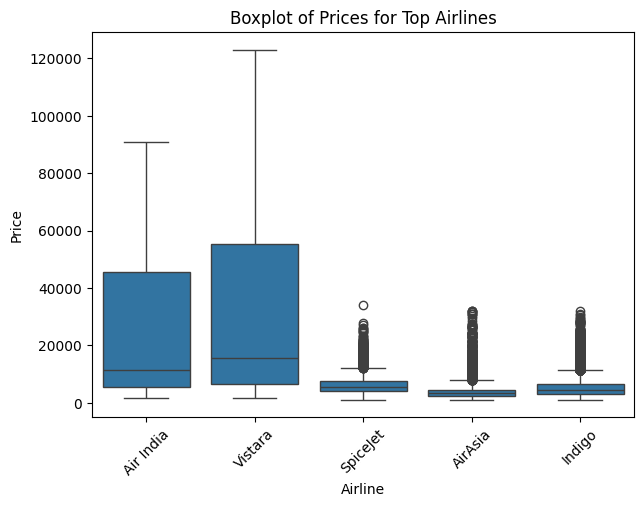

In [45]:
filtered_df = df[df['airline'].isin(top_airlines)]
# Plot the boxplot
plt.figure(figsize=(7, 5))
sns.boxplot(x='airline', y='price', data=filtered_df)
plt.title('Boxplot of Prices for Top Airlines')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

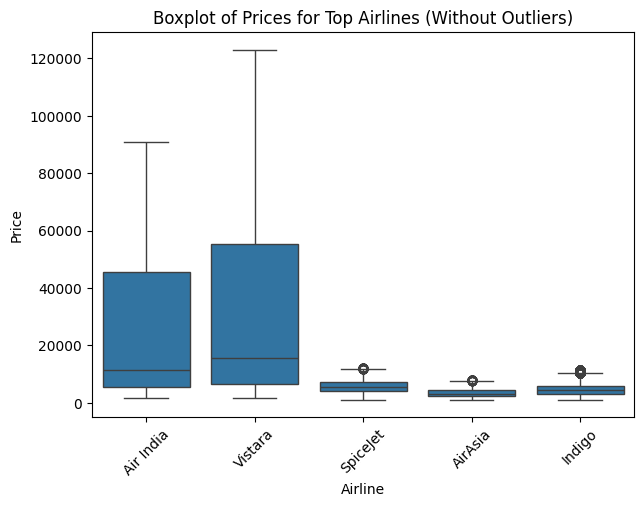

In [46]:
# Function to identify outliers using the IQR method
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


filtered_df = df[df['airline'].isin(top_airlines)]

outliers = pd.DataFrame()
for airline in top_airlines:
    airline_outliers = identify_outliers(filtered_df[filtered_df['airline'] == airline], 'price')
    outliers = pd.concat([outliers, airline_outliers])


filtered_df_no_outliers = filtered_df[~filtered_df.index.isin(outliers.index)]


plt.figure(figsize=(7, 5))
sns.boxplot(x='airline', y='price', data=filtered_df_no_outliers)
plt.title('Boxplot of Prices for Top Airlines (Without Outliers)')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

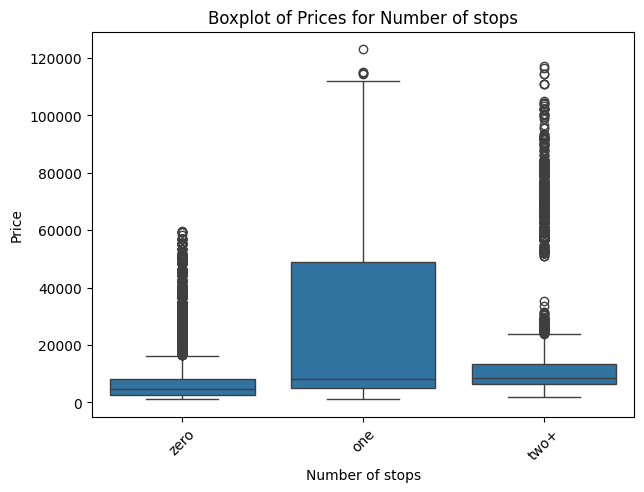

In [47]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='stop_type', y='price', data=df)
plt.title('Boxplot of Prices for Number of stops')
plt.xlabel('Number of stops')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

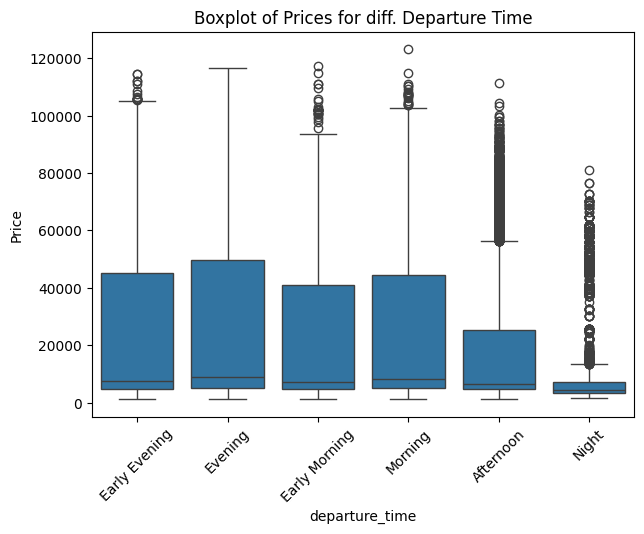

In [48]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='departure_time', y='price', data=df)
plt.title('Boxplot of Prices for diff. Departure Time')
plt.xlabel('departure_time')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

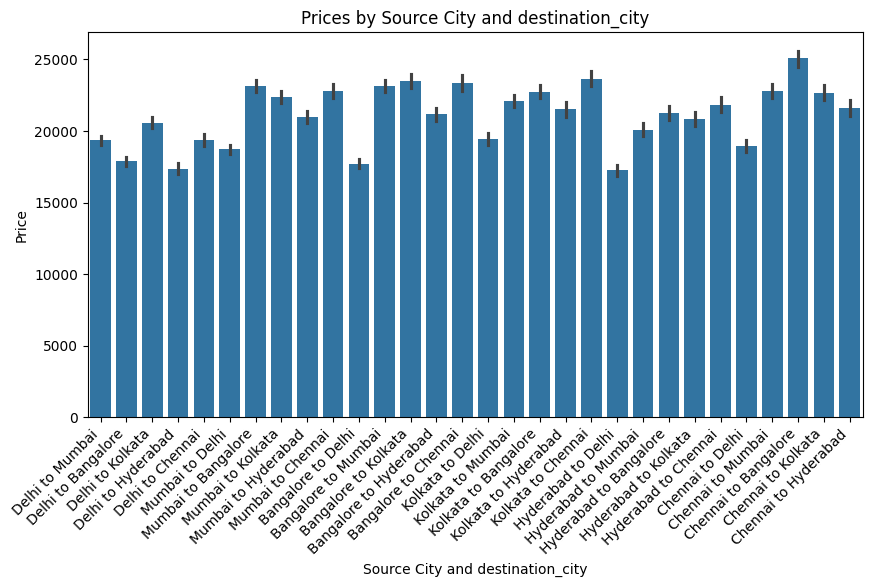

In [49]:
df['source_destination'] = df['source_city'] + ' to ' + df['destination_city']
plt.figure(figsize=(10, 5))
sns.barplot(x='source_destination', y='price', data=df)
plt.title('Prices by Source City and destination_city')
plt.xlabel('Source City and destination_city')
plt.ylabel('Price')
plt.xticks(rotation=45, ha='right') 
plt.show()


In [50]:
df['stop_type'].value_counts()

stop_type
one     250927
zero     36044
two+     13286
Name: count, dtype: int64

# Checking correlation

In [51]:
from scipy.stats import chi2_contingency # stackoverflow code :D

def cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(var1, var2))
    stats = chi2_contingency(crosstab)[0]
    cram_V = stats / (np.sum(crosstab) * (min(crosstab.shape) - 1))
    return cram_V

def cramers_col(column_name):
    col = pd.Series(np.empty(df.columns.shape), index=df.columns, name=column_name)
    for row in df:
        cram = cramers_V(df[column_name], df[row])
        col[row] = round(cram, 2)
    return col

corr = df.apply(lambda column: cramers_col(column.name))

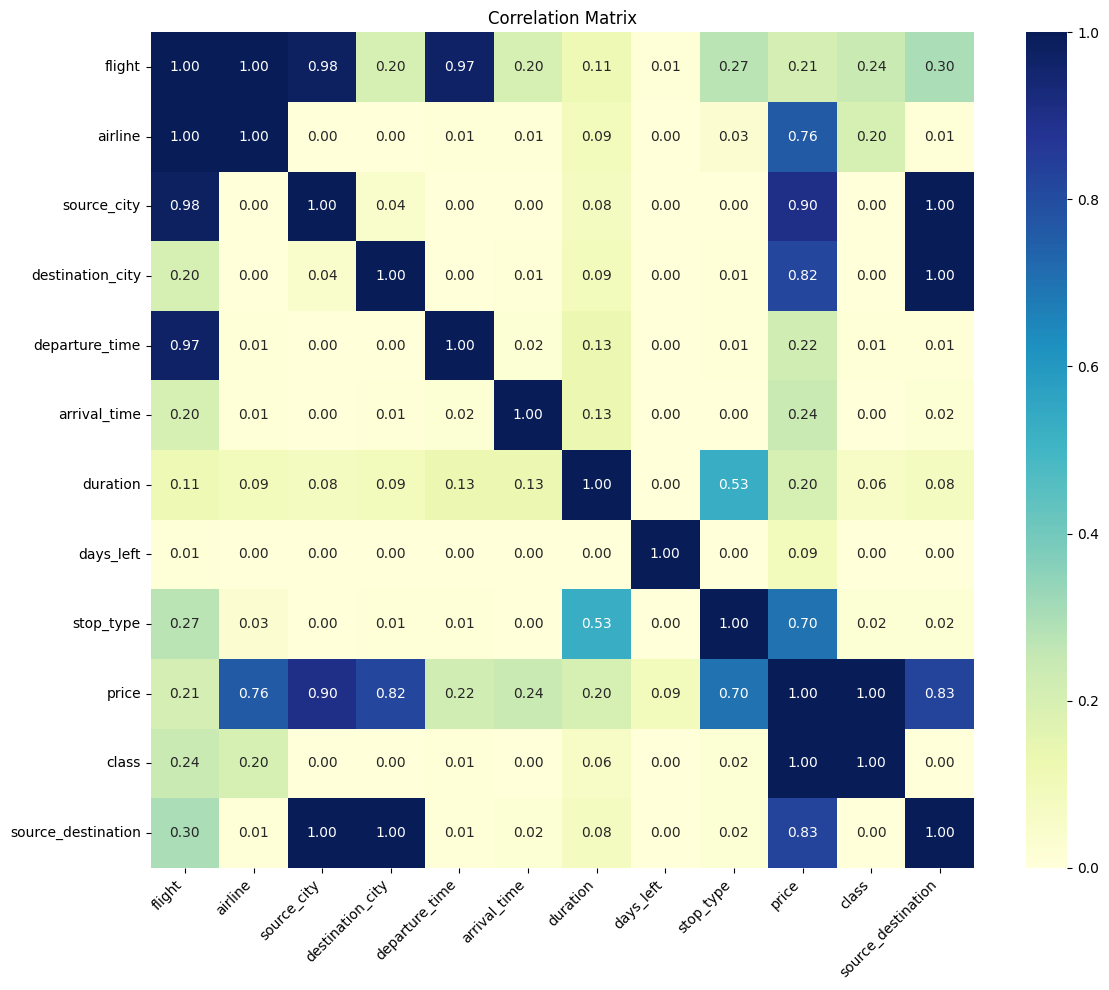

In [52]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Preprocessing

In [53]:
df.drop(['flight','source_destination'], axis=1, inplace=True)

In [54]:
from sklearn.model_selection import train_test_split
train_valid, test = train_test_split(df, train_size=0.8, shuffle=True, stratify=df['class'])

In [55]:
train, valid = train_test_split(train_valid, train_size=0.8, shuffle=True)

In [56]:
train.shape, valid.shape, test.shape

((192164, 10), (48041, 10), (60052, 10))

In [57]:
train_X, train_y = train.drop('price', axis=1).copy(), train['price'].copy()
valid_X, valid_y = valid.drop('price', axis=1).copy(), valid['price'].copy()
test_X, test_y = test.drop('price', axis=1).copy(), test['price'].copy()

In [58]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor


numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[['zero', 'one', 'two+']]))
])


cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown="ignore"))
])

class_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OrdinalEncoder(categories=[['economy', 'business']]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, ['duration', 'days_left']),
        ('ord', ordinal_pipeline, ['stop_type']),
        ('cat', cat_pipeline, ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']),
        ('class', class_pipeline, ['class'])
    ],
    remainder=numerical_pipeline 
)



In [59]:
processed_data = preprocessor.fit_transform(df)

In [60]:
processed_data.shape

(300257, 37)

In [61]:
Cols = preprocessor.get_feature_names_out()

In [62]:
pd.DataFrame(data=processed_data.toarray(), columns=Cols)

,num__duration,num__days_left,ord__stop_type,cat__airline_Air India,cat__airline_AirAsia,cat__airline_GO FIRST,cat__airline_Indigo,cat__airline_SpiceJet,cat__airline_StarAir,cat__airline_Trujet,...,cat__departure_time_Morning,cat__departure_time_Night,cat__arrival_time_Afternoon,cat__arrival_time_Early Evening,cat__arrival_time_Early Morning,cat__arrival_time_Evening,cat__arrival_time_Morning,cat__arrival_time_Night,class__class,remainder__price
0,-1.420563,-1.843862,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.208322
1,-1.385807,-1.843862,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.208322
2,1.742286,-1.843862,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.940083
3,1.985582,-1.843862,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.038338
4,-0.771310,-1.843862,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.137034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300252,0.224118,1.695700,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.581025
300253,0.224118,1.695700,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.580497
300254,1.162546,1.695700,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.539476
300255,1.544869,1.695700,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.539476


# Model training

In [63]:
from sklearn.linear_model import SGDRegressor

sgd_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('sgdregressor', SGDRegressor(max_iter=1000, eta0=0.01))
])

sgd_reg.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=Pipeline(steps=[('imputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('scaler',
                                                              StandardScaler())]),
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'days_left']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='mos...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['airline', 'source_city',
                                                   'destination_city',
                                                   'departure_time',
                                                   'arrival_time']),
                                                 ('class',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['economy',
                                                                                               'business']]))]),
                                                  ['class'])])),
                ('sgdregressor', SGDRegressor())])

In [64]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_reg, valid_X, valid_y, cv=3).sum()/3 * 100

91.14221937314481

In [65]:
cv_scores = cross_val_score(sgd_reg, valid_X, valid_y, cv=3, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
print(cv_scores)

[46072999.81566459 46521222.50787555 44953317.41823127]


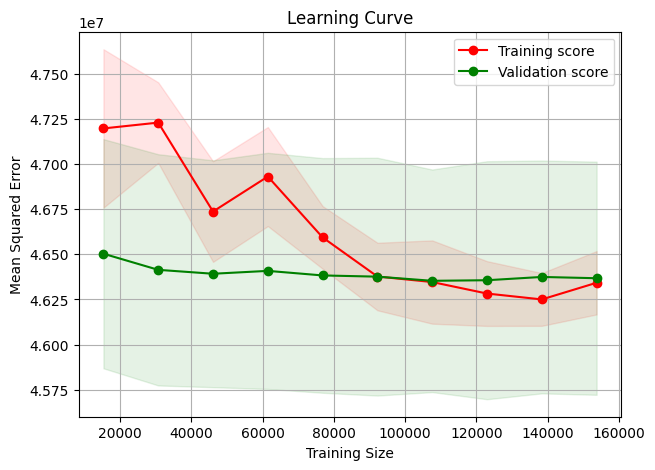

In [66]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    sgd_reg, train_X, train_y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = -np.mean(train_scores, axis=1)  
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)  
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid()
plt.show()

## 1. Generalization: The model appears to generalize well as the validation error is consistently low and does not significantly increase with more training data.
## 2. Model Performance: The relatively low MSE for both training and validation sets suggests that the model performs well on both seen and unseen data.

In [67]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'sgdregressor__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1],
    'sgdregressor__eta0': [0.001, 0.01, 0.1],
    'sgdregressor__max_iter': [1000, 2000, 3000]
}


random_search = RandomizedSearchCV(sgd_reg, param_distributions, n_iter=45, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)


random_search.fit(train_X, train_y)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'sgdregressor__max_iter': 3000, 'sgdregressor__eta0': 0.001, 'sgdregressor__alpha': 0.0001}
Best score found:  -46325224.717243746


In [68]:
final_model = random_search.best_estimator_

In [69]:
sgd_regressor = final_model.named_steps['sgdregressor']
feature_importances = sgd_regressor.coef_  # feature importances
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out() # feature names from the preprocessor
feature_importances_dict = dict(zip(feature_names, feature_importances))

for feature, importance in feature_importances_dict.items():
    print(f"Feature: {feature}, Importance: {importance}")

Feature: num__duration, Importance: 590.5118502675082
Feature: num__days_left, Importance: -1777.274816970464
Feature: ord__stop_type, Importance: 5605.874810897161
Feature: cat__airline_Air India, Importance: -1544.065616714035
Feature: cat__airline_AirAsia, Importance: -1676.7028176178412
Feature: cat__airline_GO FIRST, Importance: 381.8689810753917
Feature: cat__airline_Indigo, Importance: 657.2723691002757
Feature: cat__airline_SpiceJet, Importance: 671.5869094142818
Feature: cat__airline_StarAir, Importance: 114.1069783218895
Feature: cat__airline_Trujet, Importance: -33.564631571759726
Feature: cat__airline_Vistara, Importance: 2431.2104624414187
Feature: cat__source_city_Bangalore, Importance: 473.47597866085533
Feature: cat__source_city_Chennai, Importance: 406.36658042869493
Feature: cat__source_city_Delhi, Importance: -998.993841884908
Feature: cat__source_city_Hyderabad, Importance: -1153.7627062592928
Feature: cat__source_city_Kolkata, Importance: 1961.323369454114
Feature:

# Feature Importance Analysis for Flight Pricing Model

## 1. Numerical Features:
   - **Duration:** 
     - Positive importance (590.51), indicating that longer flight durations are associated with higher prices.
   - **Days Left:** 
     - Negative importance (-1777.27), suggesting that prices tend to decrease as the departure date approaches.

## 2. Ordinal Feature:
   - **Stop Type:** 
     - High positive importance (5605.87), suggesting that flights with more stops are priced higher.

## 3. Categorical Features:
   - **Airlines:** 
     - Air India, AirAsia, GO FIRST, Indigo, SpiceJet, StarAir, Trujet, Vistara:
       - All have positive coefficients.
       - Vistara has the highest importance (2431.21), indicating generally higher prices.
   - **Source and Destination Cities:** 
     - Kolkata:
       - High positive importance for both source (1961.32) and destination (1858.30), suggesting flights involving Kolkata are priced higher.
   - **Departure and Arrival Times:** 
     - Morning and Early Evening departures and arrivals:
       - Generally have high positive coefficients, indicating higher prices during these times.

## 4. Class:
   - **Business:** 
     - Very high positive importance (45158.58), indicating significantly higher prices for business class tickets.


# Testing Model on test sets

In [70]:
from sklearn.metrics import mean_squared_error
final_predictions = final_model.predict(test_X)
final_rmse = mean_squared_error(test_y, final_predictions, squared=False)
print(final_rmse)

6850.363810847569


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [71]:
final_model.score(test_X, test_y)

0.9086857820329135

# Saving the final model:

In [72]:
import joblib

joblib.dump(final_model, "Flight_price_predictor.pkl")

['Flight_price_predictor.pkl']